
#  End to end machine learning project


In [1]:
# Imports

import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

import psycopg2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import pearsonr
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV

In [2]:
conn = psycopg2.connect("dbname=mimic user=mimic password=Mimic@4@plhi")
cur = conn.cursor()

In [3]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "Machine_learning_ch-2"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# Goal/Framing the problem

#### The goal of this project is to create a model that predicts the length-of-stay for each patient at time of admission.for this we are using MIMIC IV dataset which contains data on patient demographics (age, sex, insurance, marital status), diagnosis (ICD-10), drg codes and ICU stay information. 

#### With all this information,  first, we need to frame the problem: is it supervised, unsupervised, or Reinforcement Learning? Is it a classification task, a regression task, or something else? Should you use batch learning or online learning techniques? 

#### it is clearly a typical supervised learning task, since we have a labeled training examples (each instance comes with the expected output, i.e., the length-of-stay for each patient at the time of admission). It is also a typical regression task, since we have to predict a value. More specifically, this is a multiple regression problem, since the system will use multiple features to make a prediction.

# Select a Performance Measure

#### The next step is to select a performance measure. A typical performance measure for regression problems is the Root Mean Square Error (RMSE). It gives an idea of how much error the system typically makes in its predictions,with a higher weight for large errors. Equation shows the mathematical formula to compute the RMSE. The RMSE is a commonly used measure of the differences between values predicted by a model and the values observed, where a lower score implies better accuracy. For example, a perfect prediction model would have an RMSE of 0. The RMSE equation for this work is given as follows, where (n) is the number of hospital admission records, ($\hat{y}$) the prediction LOS, and (y) is the actual LOS. 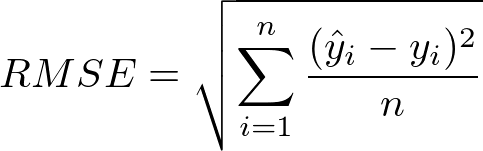


#### The ultimate goal is to develop a prediction model that results in a lower RMSE than the average or median models. There is a multitude of regression models available for predicting LOS. To determine the best regression model for this work (of the subset of models that will be evaluated), the R2 (R-squared) score will be used. The R2 is a measure of the goodness of the fit of a model. In other words, it is the proportion of the variance in the dependent variable that is predictable from the independent variables. R2 is defined as the following equation where ($y_i$) is an observed data point, ($\hat{y}$) is the mean of the observed data, and ($f_i$) the predicted model value. 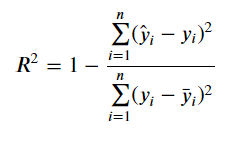Best possible R2 score is 1.0 and a negative value means it is worse than a constant model, average or median in this case.

#### Even though the RMSE is generally the preferred performance measure for regression tasks, we use another function. For example, suppose that there are many outliers. In that case, we may consider using the mean absolute error (MAE, also called the average absolute deviation) 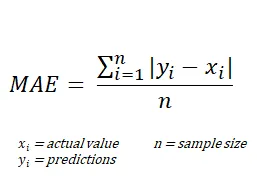

# 1. loading data from mimic-iv dataset

## 1.1 Admissions data

In [4]:
def create_pandas_table(sql_query, database = conn):
    table = pd.read_sql_query(sql_query, database)
    return table

df_admissions_data = create_pandas_table("select * from mimic_core.admissions")
print (df_admissions_data.shape)
df_admissions_data.head()

(524520, 15)


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,edregtime,edouttime,hospital_expire_flag
0,12427812,21593330,2184-01-06 11:51:00,2184-01-10 11:45:00,NaT,URGENT,PHYSICIAN REFERRAL,HOME,Other,ENGLISH,None,UNKNOWN,NaT,NaT,0
1,14029832,22059088,2120-01-18 01:28:00,2120-01-20 16:13:00,NaT,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,None,OTHER,NaT,NaT,0
2,14495017,22484010,2175-01-28 15:41:00,2175-01-29 16:00:00,NaT,DIRECT EMER.,PHYSICIAN REFERRAL,HOME,Other,?,None,WHITE,NaT,NaT,0
3,13676048,23865469,2193-01-19 05:27:00,2193-01-24 18:59:00,NaT,URGENT,PHYSICIAN REFERRAL,HOME,Other,?,MARRIED,WHITE,NaT,NaT,0
4,13831972,27763544,2131-01-27 04:03:00,2131-01-27 05:39:00,NaT,EU OBSERVATION,EMERGENCY ROOM,None,Medicaid,ENGLISH,SINGLE,WHITE,2131-01-26 22:19:00,2131-01-27 05:39:00,0


## 1.2 Patients data

In [5]:
df_patients_data = create_pandas_table("select * from mimic_core.patients")
print (df_patients_data.shape)
df_patients_data.head() 

(383220, 6)


,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10002723,F,0,2128,2017 - 2019,None
1,10003939,M,0,2184,2008 - 2010,None
2,10004222,M,0,2161,2014 - 2016,None
3,10005325,F,0,2154,2011 - 2013,None
4,10007338,F,0,2153,2017 - 2019,None


## 1.3 DRG data

In [6]:
df_drg_data = create_pandas_table("select * from mimic_Hosp.drgcodes")
print (df_drg_data.shape)
df_drg_data.head()

(1168135, 7)


,subject_id,hadm_id,drg_type,drg_code,description,drg_severity,drg_mortality
0,11603789,25552978,APR,5402,Cesarean Delivery,2.0,1.0
1,11603789,25552978,APR,5402,Cesarean Delivery,2.0,1.0
2,11603789,25552978,HCFA,765,CESAREAN SECTION W CC/MCC,NaN,NaN
3,16809467,29803749,APR,5601,Vaginal Delivery,1.0,1.0
4,16809467,29803749,APR,5601,Vaginal Delivery,1.0,1.0


## 1.4 diagnosis data

In [7]:
df_diagnosis_data = create_pandas_table("select * from mimic_Hosp.diagnoses_icd")
print (df_diagnosis_data.shape)
df_diagnosis_data

(4677924, 5)


,subject_id,hadm_id,seq_num,icd_code,icd_version
0,11603789,25552978,3,65801,9
1,11603789,25552978,4,64881,9
2,11603789,25552978,5,V270,9
3,11603789,25552978,1,65221,9
4,11603789,25552978,2,64421,9
...,...,...,...,...,...
4677919,13747041,25594844,10,N189,10
4677920,13747041,25594844,5,N179,10
4677921,13747041,25594844,6,R531,10
4677922,13747041,25594844,1,T50901A,10


## 1.5 ICU data

In [8]:
df_icu_data = create_pandas_table("select * from mimic_icu.icustays")
print (df_icu_data.shape)
df_icu_data.head()

(69619, 8)


,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,17823467,27561644,35964304,Coronary Care Unit (CCU),Coronary Care Unit (CCU),2138-05-09 05:08:00,2138-05-11 16:55:34,2.491366
1,15772648,26147926,39637383,Trauma SICU (TSICU),Trauma SICU (TSICU),2146-06-18 18:35:00,2146-06-21 17:41:00,2.962500
2,13713711,25848902,36363748,Trauma SICU (TSICU),Trauma SICU (TSICU),2157-09-15 15:30:00,2157-09-17 18:18:49,2.117234
3,13173210,22338446,38210858,Coronary Care Unit (CCU),Coronary Care Unit (CCU),2178-02-12 17:13:50,2178-02-15 14:55:14,2.903750
4,10213765,28522861,39765853,Trauma SICU (TSICU),Trauma SICU (TSICU),2113-04-10 14:11:00,2113-04-11 10:55:19,0.864109


# 2. Data Exploration and Feature Engineering

#### Systems capability of learning depends upon the enough relevant features that training data contains. Coming up with a good set of features to train on is an important part of a Machine Learning project's success. This process is called as Feature engineering. 

#### Feature engineering involves following steps:
#####  1. Feature selection (selecting the most useful features to train on among existing features)
#####  2. Feature extraction (combining existing features to produce a more useful one — dimensionality reduction algorithms can help)
#####  3. Creating new features by gathering new data
   


#### In this section, we'll examine the various imported MIMIC DataFrames to understand how the data is distributed. Additionaly, we need to figure out a strategy to extract the target Length-of-Stay (LOS) values and understand what features (independent variables) may be useful in predicting LOS. 

## 2.1 Admissions vs data exploration

#### The ADMISSIONS table gives information regarding a patient’s admission to the hospital. Since each unique hospital visit for a patient is assigned a unique hadm_id, the ADMISSIONS table can be considered as a definition table for hadm_id. Information available includes timing information for admission and discharge, demographic information, the source of the admission, and so on.

In [9]:
df_admissions_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524520 entries, 0 to 524519
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   subject_id            524520 non-null  int64         
 1   hadm_id               524520 non-null  int64         
 2   admittime             524520 non-null  datetime64[ns]
 3   dischtime             524520 non-null  datetime64[ns]
 4   deathtime             9356 non-null    datetime64[ns]
 5   admission_type        524520 non-null  object        
 6   admission_location    464083 non-null  object        
 7   discharge_location    397337 non-null  object        
 8   insurance             524520 non-null  object        
 9   language              524520 non-null  object        
 10  marital_status        458387 non-null  object        
 11  ethnicity             524520 non-null  object        
 12  edregtime             312172 non-null  datetime64[ns]
 13 

In [10]:
print('Dataset has {} number of unique admission events.'.format(df_admissions_data['hadm_id'].nunique()))
print('Dataset has {} number of unique patients.'.format(df_admissions_data['subject_id'].nunique()))

Dataset has 524520 number of unique admission events.
Dataset has 257366 number of unique patients.


## 2.1.1 Length-of-Stay (Feature Engineering)

In [11]:
# Convert timedelta type into float 'days', 86400 seconds in a day
df_admissions_data['LOS'] = (df_admissions_data['dischtime'] - df_admissions_data['admittime']).dt.total_seconds()/86400

In [12]:
# Verify
df_admissions_data[['admittime', 'dischtime', 'LOS']].head()

,admittime,dischtime,LOS
0,2184-01-06 11:51:00,2184-01-10 11:45:00,3.995833
1,2120-01-18 01:28:00,2120-01-20 16:13:00,2.614583
2,2175-01-28 15:41:00,2175-01-29 16:00:00,1.013194
3,2193-01-19 05:27:00,2193-01-24 18:59:00,5.563889
4,2131-01-27 04:03:00,2131-01-27 05:39:00,0.066667


In [13]:
df_admissions_data['LOS'].describe()

count    524520.000000
mean          4.561174
std           7.596999
min          -0.979167
25%           1.236111
50%           2.671528
75%           4.960417
max        1191.416667
Name: LOS, dtype: float64

In [14]:
# Look at what is happening with negative LOS values
df_admissions_data[df_admissions_data['LOS'] < 0]

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,edregtime,edouttime,hospital_expire_flag,LOS
425,17316473,28200091,2186-02-17 12:54:00,2186-02-17 04:20:00,NaT,EW EMER.,PACU,None,Other,ENGLISH,None,WHITE,NaT,NaT,0,-0.356944
1598,14659176,21162467,2174-06-15 22:01:00,2174-06-15 14:50:00,2174-06-15 00:03:00,ELECTIVE,None,DIED,Medicaid,ENGLISH,None,OTHER,NaT,NaT,1,-0.299306
2301,14556829,27223222,2160-01-04 20:43:00,2160-01-04 01:50:00,2160-01-04 01:50:00,ELECTIVE,None,DIED,Medicaid,ENGLISH,None,BLACK/AFRICAN AMERICAN,NaT,NaT,1,-0.786806
6173,13362952,25586069,2173-05-02 18:50:00,2173-05-02 09:06:00,2173-05-02 09:06:00,ELECTIVE,None,DIED,Other,ENGLISH,None,WHITE,NaT,NaT,1,-0.405556
7329,12129653,27981870,2116-04-05 16:48:00,2116-04-05 00:00:00,2116-04-05 23:10:00,OBSERVATION ADMIT,TRANSFER FROM HOSPITAL,DIED,Other,ENGLISH,None,UNKNOWN,2116-04-05 14:26:00,2116-04-05 18:04:00,1,-0.700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498278,13659453,23252384,2145-05-20 05:08:00,2145-05-20 02:20:00,NaT,EW EMER.,EMERGENCY ROOM,HOME,Other,ENGLISH,SINGLE,WHITE,2145-05-20 03:20:00,2145-05-20 08:02:00,0,-0.116667
505328,13316652,22658929,2130-05-11 14:55:00,2130-05-11 02:30:00,2130-05-11 22:23:00,EW EMER.,EMERGENCY ROOM,HOME,Other,ENGLISH,MARRIED,WHITE,2130-05-11 10:09:00,2130-05-11 16:31:00,1,-0.517361
508900,13535122,21247013,2177-08-15 11:56:00,2177-08-15 01:00:00,2177-08-15 01:00:00,EW EMER.,EMERGENCY ROOM,DIED,Other,?,MARRIED,ASIAN,2177-08-15 08:47:00,2177-08-15 13:11:00,1,-0.455556
509242,15838787,29390236,2137-07-23 16:58:00,2137-07-23 00:01:00,2137-07-23 23:09:00,EW EMER.,EMERGENCY ROOM,DIED,Other,ENGLISH,MARRIED,WHITE,2137-07-23 15:17:00,2137-07-23 18:41:00,1,-0.706250


In [15]:
# Drop rows with negative LOS, usually related to a time of death before admission
df_admissions_data['LOS'][df_admissions_data['LOS'] > 0].describe()

count    524344.000000
mean          4.562815
std           7.597743
min           0.000694
25%           1.237500
50%           2.672222
75%           4.961111
max        1191.416667
Name: LOS, dtype: float64

In [16]:
# Drop LOS < 0 
df_admissions_data = df_admissions_data[df_admissions_data['LOS'] > 0]

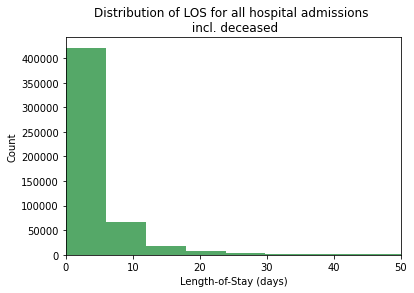

In [17]:
# Plot of LOS Distribution
plt.hist(df_admissions_data['LOS'], bins=200, color = '#55a868')
plt.xlim(0, 50)
plt.title('Distribution of LOS for all hospital admissions \n incl. deceased')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show();

In [18]:
# Pre-emptively drop some columns that is not needed anymore
df_admissions_data.drop(columns=['dischtime', 'edregtime', 'edouttime', 'hospital_expire_flag'], inplace=True)

In [19]:
df_admissions_data

,subject_id,hadm_id,admittime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,LOS
0,12427812,21593330,2184-01-06 11:51:00,NaT,URGENT,PHYSICIAN REFERRAL,HOME,Other,ENGLISH,None,UNKNOWN,3.995833
1,14029832,22059088,2120-01-18 01:28:00,NaT,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,None,OTHER,2.614583
2,14495017,22484010,2175-01-28 15:41:00,NaT,DIRECT EMER.,PHYSICIAN REFERRAL,HOME,Other,?,None,WHITE,1.013194
3,13676048,23865469,2193-01-19 05:27:00,NaT,URGENT,PHYSICIAN REFERRAL,HOME,Other,?,MARRIED,WHITE,5.563889
4,13831972,27763544,2131-01-27 04:03:00,NaT,EU OBSERVATION,EMERGENCY ROOM,None,Medicaid,ENGLISH,SINGLE,WHITE,0.066667
...,...,...,...,...,...,...,...,...,...,...,...,...
524515,17892964,20786062,2180-09-17 00:00:00,NaT,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,HOME,Medicare,ENGLISH,SINGLE,WHITE,1.567361
524516,17137572,20943099,2147-08-01 17:41:00,NaT,EW EMER.,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,DIVORCED,HISPANIC/LATINO,0.992361
524517,19389857,23176714,2189-03-01 00:58:00,NaT,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,HOME,Other,ENGLISH,MARRIED,WHITE,1.600000
524518,12298845,22347500,2138-05-31 00:00:00,NaT,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,HOME HEALTH CARE,Other,ENGLISH,MARRIED,WHITE,4.701389


## 2.1.2 Deathtime

#### Patients who died at the hospital will later be dropped from the DataFrame as they would bias the LOS since they  were never discharged 'alive' from the hospital. In other words, LOS would be shorter for this group.

In [20]:
# Mark admissions where patients died in boolean column
df_admissions_data['Deceased'] = df_admissions_data['deathtime'].notnull().map({True:1, False:0})

In [21]:
print("{} of {} patients died in the hospital".format(df_admissions_data['Deceased'].sum(), 
                                                     df_admissions_data['subject_id'].nunique()))

9259 of 257284 patients died in the hospital


In [22]:
# description of LOS of patients who are alive
df_admissions_data['LOS'].loc[df_admissions_data['Deceased'] == 0].describe()

count    515085.000000
mean          4.465960
std           7.177867
min           0.000694
25%           1.228472
50%           2.654167
75%           4.904167
max         467.090278
Name: LOS, dtype: float64

In [23]:
# Hospital LOS metrics for later comparison
actual_mean_los = df_admissions_data['LOS'].loc[df_admissions_data['Deceased'] == 0].mean() 
actual_median_los = df_admissions_data['LOS'].loc[df_admissions_data['Deceased'] == 0].median() 

print(actual_mean_los)
print(actual_median_los)

4.465960248739961
2.654166666666667


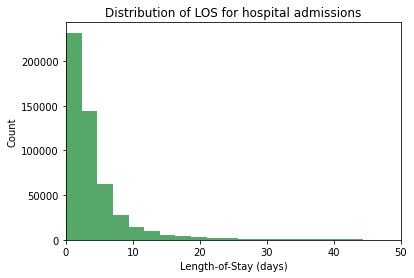

In [24]:
plt.hist(df_admissions_data['LOS'].loc[df_admissions_data['Deceased'] == 0], bins=200, color = '#55a868')
plt.xlim(0, 50)
plt.title('Distribution of LOS for hospital admissions')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show();

## 2.1.3 Ethnicity

In [25]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html


In [26]:
df_admissions_data['ethnicity'].value_counts()

WHITE                            337947
BLACK/AFRICAN AMERICAN            80502
HISPANIC/LATINO                   29880
OTHER                             26833
ASIAN                             24515
UNKNOWN                           19393
UNABLE TO OBTAIN                   3738
AMERICAN INDIAN/ALASKA NATIVE      1536
Name: ethnicity, dtype: int64

In [27]:
# Compress the number of ethnicity categories

df_admissions_data['ethnicity'].replace(['UNABLE TO OBTAIN', 'OTHER',  
                         'UNKNOWN'], value='OTHER/UNKNOWN', inplace=True)

df_admissions_data['ethnicity'].value_counts()

WHITE                            337947
BLACK/AFRICAN AMERICAN            80502
OTHER/UNKNOWN                     49964
HISPANIC/LATINO                   29880
ASIAN                             24515
AMERICAN INDIAN/ALASKA NATIVE      1536
Name: ethnicity, dtype: int64

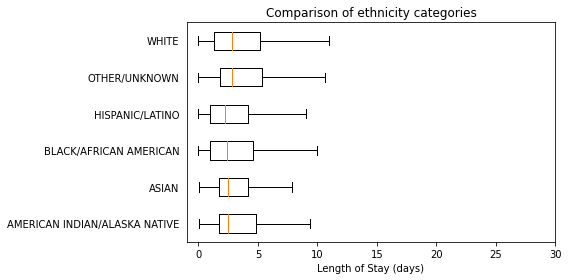

In [28]:
# Re-usable plotting function 
## (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html?highlight=reset_index#pandas.DataFrame.reset_index)

def plot_los_groupby(variable, size=(7,4)):
    ''' 
    Plot Median LOS by df categorical series name 
    '''
    results = df_admissions_data[[variable, 'LOS']].groupby(variable).median().reset_index()
    values = list(results['LOS'].values)
    labels = list(results[variable].values)

    fig, ax = plt.subplots(figsize=size)
    ind = range(len(results))
    ax.barh(ind, values, align='center', height=0.6, color = '#55a868', alpha=0.8)
    ax.set_yticks(ind)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Median Length of Stay (days)')
    ax.tick_params(left=False, top=False, right=False) 
    ax.set_title('Comparison of {} labels'.format(variable))
    
    plt.tight_layout()
    plt.show();
    
    
# Re-usable boxplot function
def boxplot_los_groupby(variable, los_range=(-1, 30), size=(8,4)):
    ''' 
    Boxplot of LOS by df_admissions_data categorical series name 
    '''
    results = df_admissions_data[[variable, 'LOS']].groupby(variable).median().reset_index()

    categories = results[variable].values.tolist()

    hist_data = []
    for cat in categories:
        hist_data.append(df_admissions_data['LOS'].loc[df_admissions_data[variable]==cat].values)

    fig, ax = plt.subplots(figsize=size)
    ax.boxplot(hist_data, 0, '', vert=False)
    ax.set_xlim(los_range)
    ax.set_yticklabels(categories)
    ax.set_xlabel('Length of Stay (days)')
    ax.tick_params(left=False, right=False) 
    ax.set_title('Comparison of {} categories'.format(variable))
    plt.tight_layout()
    plt.show();

boxplot_los_groupby('ethnicity', los_range=(-1, 30))

## 2.1.4 Admission Type

In [29]:
df_admissions_data['admission_type'].value_counts()

EW EMER.                       157961
EU OBSERVATION                 100886
ELECTIVE                        72054
OBSERVATION ADMIT               55526
URGENT                          47959
SURGICAL SAME DAY ADMISSION     41100
DIRECT EMER.                    21591
DIRECT OBSERVATION              20008
AMBULATORY OBSERVATION           7259
Name: admission_type, dtype: int64

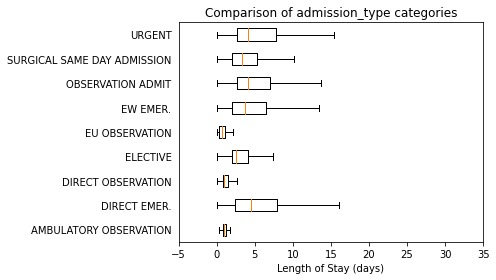

In [30]:
boxplot_los_groupby('admission_type', los_range=(-5, 35), size=(7, 4))


## 2.1.6 Insurance

In [31]:
df_admissions_data['insurance'].value_counts()


Other       301962
Medicare    171441
Medicaid     50941
Name: insurance, dtype: int64

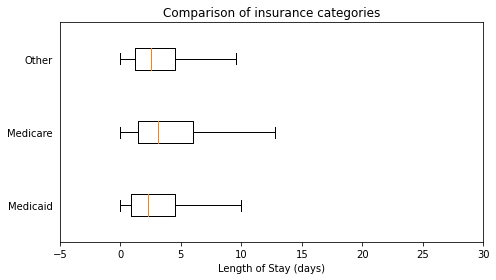

In [32]:
boxplot_los_groupby('insurance', los_range=(-5, 30), size=(7, 4))

## 2.1.7 Marital status

In [33]:
df_admissions_data['marital_status'].value_counts(dropna=False)

MARRIED     195274
SINGLE      180395
NaN          66084
WIDOWED      48839
DIVORCED     33752
Name: marital_status, dtype: int64

In [34]:
# Fix NaNs and file under 'UNKNOWN'
df_admissions_data['marital_status'] = df_admissions_data['marital_status'].fillna('Unknown')
df_admissions_data['marital_status'].value_counts(dropna=False)

MARRIED     195274
SINGLE      180395
Unknown      66084
WIDOWED      48839
DIVORCED     33752
Name: marital_status, dtype: int64

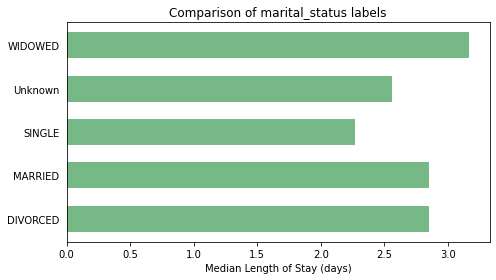

In [35]:
plot_los_groupby('marital_status')

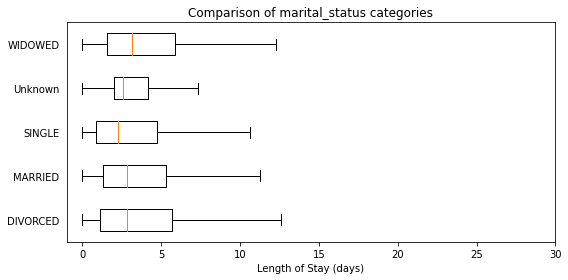

In [36]:
boxplot_los_groupby('marital_status')

## 2.2 diagnoses_icd data Exploration

In [37]:
df_diagnosis_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4677924 entries, 0 to 4677923
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   subject_id   int64 
 1   hadm_id      int64 
 2   seq_num      int64 
 3   icd_code     object
 4   icd_version  int64 
dtypes: int64(4), object(1)
memory usage: 178.4+ MB


In [38]:
# splitting the datset into two, one with icd9 version and other with icd10version

In [39]:
x = 9
df_diagnosis_data1 = df_diagnosis_data[df_diagnosis_data['icd_version'] == x]
df_diagnosis_data1

,subject_id,hadm_id,seq_num,icd_code,icd_version
0,11603789,25552978,3,65801,9
1,11603789,25552978,4,64881,9
2,11603789,25552978,5,V270,9
3,11603789,25552978,1,65221,9
4,11603789,25552978,2,64421,9
...,...,...,...,...,...
2523464,14396614,29918558,5,7242,9
2523466,14396614,29918558,6,V4987,9
2523467,14396614,29918558,1,78659,9
2523764,18564065,21575927,2,7840,9


In [40]:
df_diagnosis_data2 = df_diagnosis_data[df_diagnosis_data['icd_version'] > x]
df_diagnosis_data2.shape
df_diagnosis_data2.head(10)

,subject_id,hadm_id,seq_num,icd_code,icd_version
2090755,18335503,21596415,7,O99282,10
2090756,18335503,21596415,3,A084,10
2090757,18335503,21596415,4,R931,10
2090758,18335503,21596415,6,J45909,10
2090759,18335503,21596415,1,O99612,10
2090760,18335503,21596415,2,E861,10
2090761,18335503,21596415,5,O99512,10
2202718,11582944,21283853,3,O99280,10
2202719,11582944,21283853,2,E039,10
2202720,11582944,21283853,4,O621,10


In [41]:
print('There are {} unique ICD9 codes in this dataset.'.format(df_diagnosis_data1['icd_code'].value_counts().count()))

There are 9200 unique ICD9 codes in this dataset.


In [42]:
print('There are {} unique ICD10 codes in this dataset.'.format(df_diagnosis_data2['icd_code'].value_counts().count()))

There are 17555 unique ICD10 codes in this dataset.


In [43]:
# Because it's not feasible to have 6984 unique values to use as features for predicting LOS, 
# we need to reduce the diagnosis into more general categories. 
# ICD9  categorized as the following (https://en.wikipedia.org/wiki/List_of_ICD-9_codes):

# 001–139: infectious and parasitic diseases
# 140–239: neoplasms
# 240–279: endocrine, nutritional and metabolic diseases, and immunity disorders
# 280–289: diseases of the blood and blood-forming organs
# 290–319: mental disorders
# 320–389: diseases of the nervous system and sense organs
# 390–459: diseases of the circulatory system
# 460–519: diseases of the respiratory system
# 520–579: diseases of the digestive system
# 580–629: diseases of the genitourinary system
# 630–679: complications of pregnancy, childbirth, and the puerperium
# 680–709: diseases of the skin and subcutaneous tissue
# 710–739: diseases of the musculoskeletal system and connective tissue
# 740–759: congenital anomalies
# 760–779: certain conditions originating in the perinatal period
# 780–799: symptoms, signs, and ill-defined conditions
# 800–999: injury and poisoning
# E and V codes: external causes of injury and supplemental classification, using 999 as placeholder even though it overlaps with complications of medical care
# Now the task is to re-code the in terms of these category groups.

In [44]:
# Filter out E and V codes since processing will be done on the numeric first 3 values

df_diagnosis_data1['recode'] = df_diagnosis_data1['icd_code']
df_diagnosis_data1

df_diagnosis_data1['recode'] = df_diagnosis_data1['recode'][~df_diagnosis_data1['recode'].str.contains("[a-zA-Z]").fillna(False)]
df_diagnosis_data1['recode'].fillna(value='999', inplace=True)
df_diagnosis_data1

/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jupyter-remerine/.local/lib/python3.6/site-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

,subject_id,hadm_id,seq_num,icd_code,icd_version,recode
0,11603789,25552978,3,65801,9,65801
1,11603789,25552978,4,64881,9,64881
2,11603789,25552978,5,V270,9,999
3,11603789,25552978,1,65221,9,65221
4,11603789,25552978,2,64421,9,64421
...,...,...,...,...,...,...
2523464,14396614,29918558,5,7242,9,7242
2523466,14396614,29918558,6,V4987,9,999
2523467,14396614,29918558,1,78659,9,78659
2523764,18564065,21575927,2,7840,9,7840


In [45]:
df_diagnosis_data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2508398 entries, 0 to 2523765
Data columns (total 6 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   subject_id   int64 
 1   hadm_id      int64 
 2   seq_num      int64 
 3   icd_code     object
 4   icd_version  int64 
 5   recode       object
dtypes: int64(4), object(2)
memory usage: 134.0+ MB


In [46]:
# https://stackoverflow.com/questions/46168450/replace-specific-range-of-values-in-data-frame-pandas
df_diagnosis_data1['recode'] = df_diagnosis_data1['recode'].str.slice(start=0, stop=3, step=1)
df_diagnosis_data1['recode'] = df_diagnosis_data1['recode'].astype(int)

/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [47]:
# ICD-9 Main Category ranges
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390), 
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

# Associated category names
diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin', 
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
             16: 'injury', 17: 'misc'}

# Re-code in terms of integer   "https://thispointer.com/numpy-where-tutorial-examples-python/"
for num, cat_range in enumerate(icd9_ranges):
    df_diagnosis_data1['recode'] = np.where(df_diagnosis_data1['recode'].between(cat_range[0],cat_range[1]), 
            num, df_diagnosis_data1['recode'])
    
# Convert integer to category name using diag_dict
df_diagnosis_data1['recode'] = df_diagnosis_data1['recode']
df_diagnosis_data1['cat'] = df_diagnosis_data1['recode'].replace(diag_dict)

/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [48]:
# Verify
df_diagnosis_data1.head(50)

,subject_id,hadm_id,seq_num,icd_code,icd_version,recode,cat
0,11603789,25552978,3,65801,9,10,pregnancy
1,11603789,25552978,4,64881,9,10,pregnancy
2,11603789,25552978,5,V270,9,16,injury
3,11603789,25552978,1,65221,9,10,pregnancy
4,11603789,25552978,2,64421,9,10,pregnancy
5,16809467,29803749,4,66982,9,10,pregnancy
6,16809467,29803749,1,64511,9,10,pregnancy
7,16809467,29803749,2,64811,9,10,pregnancy
8,16809467,29803749,5,V270,9,16,injury
9,16809467,29803749,3,2449,9,2,endocrine


In [49]:
# Create list of diagnoses for each admission
hadm_list = df_diagnosis_data1.groupby('hadm_id')['cat'].apply(list).reset_index()
hadm_list.head()

,hadm_id,cat
0,20000019,"[injury, circulatory, blood, genitourinary, en..."
1,20000041,"[endocrine, muscular, endocrine, injury, injur..."
2,20000055,"[injury, injury]"
3,20000057,"[injury, endocrine, muscular, muscular, respir..."
4,20000095,"[injury, injury, injury]"


In [50]:
# Convert column of diagnoses list into hospital admission-item matrix 
# "https://stackoverflow.com/questions/29034928/pandas-convert-a-column-of-list-to-dummies"

hadm_item = pd.get_dummies(hadm_list['cat'].apply(pd.Series).stack()).sum(level=0)
hadm_item.head(10)

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,1,1,1,0,3,2,1,2,0,0,0,0,0,0,0,1,0
1,0,1,0,1,3,0,0,4,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
3,1,1,0,0,1,0,0,7,0,1,5,0,4,0,1,2,0
4,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0
6,1,6,0,4,2,1,1,2,0,0,0,0,0,0,0,0,1
7,0,1,0,3,0,0,1,1,1,0,2,0,0,0,1,0,0
8,0,4,0,1,1,0,0,2,0,0,0,0,1,0,0,0,0
9,0,0,0,0,2,2,0,1,2,0,0,0,0,0,0,0,0


In [51]:
# .apply(Series) converts the series of lists to a dataframe
# .stack() puts everything in one column again (creating a multi-level index)
# .pd.get_dummies( ) creating the dummies
# .sum(level=0) for remerging the different rows that should be one row (by summing up the second level, only keeping the original level (level=0))

In [52]:
# Join back with HADM_ID, will merge with main admissions DF later
hadm_item = hadm_item.join(hadm_list['hadm_id'], how="outer")
hadm_item.head()

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,hadm_id
0,1,1,1,0,3,2,1,2,0,0,0,0,0,0,0,1,0,20000019
1,0,1,0,1,3,0,0,4,0,0,1,0,0,0,0,0,0,20000041
2,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,20000055
3,1,1,0,0,1,0,0,7,0,1,5,0,4,0,1,2,0,20000057
4,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,20000095


In [53]:
# Merge with main admissions df_diagnosis_data1
df_admissions_data = df_admissions_data.merge(hadm_item, how='inner', on='hadm_id')

In [54]:
# Verify Merge
df_admissions_data.head(10)

,subject_id,hadm_id,admittime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,...,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,14495017,22484010,2175-01-28 15:41:00,NaT,DIRECT EMER.,PHYSICIAN REFERRAL,HOME,Other,?,Unknown,...,0,0,0,0,0,0,0,1,0,0
1,13831972,27763544,2131-01-27 04:03:00,NaT,EU OBSERVATION,EMERGENCY ROOM,None,Medicaid,ENGLISH,SINGLE,...,0,0,0,0,0,2,0,0,0,0
2,18523038,25414328,2142-08-26 17:14:00,NaT,DIRECT OBSERVATION,PROCEDURE SITE,None,Other,ENGLISH,SINGLE,...,4,0,0,0,0,0,0,0,0,0
3,16705931,20580522,2174-10-24 11:30:00,NaT,DIRECT OBSERVATION,PHYSICIAN REFERRAL,None,Other,ENGLISH,MARRIED,...,2,0,2,0,1,0,0,1,0,0
4,10903424,22568585,2181-01-31 13:09:00,NaT,EU OBSERVATION,EMERGENCY ROOM,None,Other,ENGLISH,SINGLE,...,1,3,0,0,0,0,0,0,0,0
5,15030422,21975876,2149-09-21 23:54:00,NaT,EU OBSERVATION,EMERGENCY ROOM,None,Other,ENGLISH,SINGLE,...,1,2,0,0,0,0,0,0,0,0
6,19288517,24130407,2166-11-16 08:28:00,NaT,EU OBSERVATION,EMERGENCY ROOM,None,Other,ENGLISH,MARRIED,...,0,0,0,0,0,0,1,0,0,0
7,14402927,23499598,2131-06-14 18:10:00,NaT,AMBULATORY OBSERVATION,PACU,None,Medicare,ENGLISH,MARRIED,...,0,0,1,0,2,1,0,0,1,0
8,16426569,27275637,2112-08-16 18:33:00,NaT,DIRECT OBSERVATION,CLINIC REFERRAL,None,Medicare,ENGLISH,SINGLE,...,3,0,0,1,1,1,0,0,1,0
9,13021846,22107482,2123-09-30 07:15:00,NaT,AMBULATORY OBSERVATION,PACU,None,Other,ENGLISH,DIVORCED,...,6,0,0,0,0,0,0,0,0,0


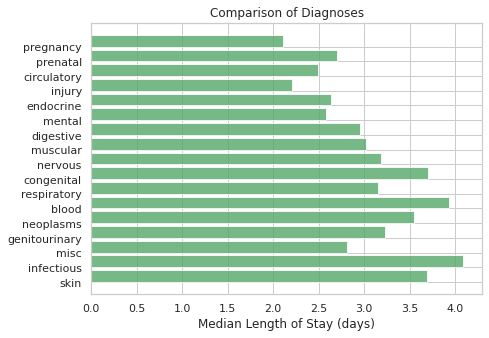

In [55]:
# Look at the median LOS by diagnosis category
diag_cat_list = ['skin', 'infectious',  'misc', 'genitourinary', 'neoplasms', 'blood', 'respiratory', 
                  'congenital','nervous', 'muscular', 'digestive', 'mental', 'endocrine', 'injury',
                 'circulatory', 'prenatal',  'pregnancy']

results = []
for variable in diag_cat_list:
    results.append(df_admissions_data[[variable, 'LOS']].groupby(variable).median().reset_index().values[1][1])

sns.set(style="whitegrid")
#sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(7,5))
ind = range(len(results))
ax.barh(ind, results, align='edge', color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(diag_cat_list)
ax.set_xlabel('Median Length of Stay (days)')
ax.tick_params(left=False, right=False, top=False) 
ax.set_title('Comparison of Diagnoses'.format(variable))
plt.show();

## 2.3 Patients data Exploration

In [56]:
df_patients_data.head()

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10002723,F,0,2128,2017 - 2019,None
1,10003939,M,0,2184,2008 - 2010,None
2,10004222,M,0,2161,2014 - 2016,None
3,10005325,F,0,2154,2011 - 2013,None
4,10007338,F,0,2153,2017 - 2019,None


In [57]:
print('There are {} unique anchor_age in this dataset.'.format(df_patients_data['anchor_age'].value_counts().count()))

There are 74 unique anchor_age in this dataset.


In [58]:
df_patients_data['gender'].value_counts()

F    200226
M    182994
Name: gender, dtype: int64

In [59]:
df_patients_data['gender']

0         F
1         M
2         M
3         F
4         F
         ..
383215    M
383216    M
383217    M
383218    M
383219    M
Name: gender, Length: 383220, dtype: object

## 2.3.1 Age (Feature Engineering)

In [60]:
df_patients_data = df_patients_data[['subject_id', 'anchor_age', 'gender']]
df_patients_data.head()

,subject_id,anchor_age,gender
0,10002723,0,F
1,10003939,0,M
2,10004222,0,M
3,10005325,0,F
4,10007338,0,F


In [61]:
# Merging the both the main dataframe with patients dataframe

In [62]:
df_admissions_data = df_admissions_data.merge(df_patients_data, how='inner', on='subject_id')

In [63]:
df_admissions_data['anchor_age'].isnull().sum()

0

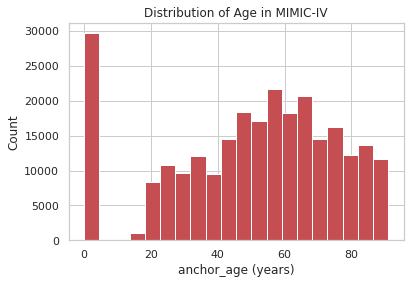

In [64]:
#Distribution of Age in Mimic iv dataset

plt.hist(df_admissions_data['anchor_age'], bins=20, color='#c44e52')
plt.ylabel('Count')
plt.xlabel('anchor_age (years)')
plt.title('Distribution of Age in MIMIC-IV')
plt.tick_params(left=False, bottom=False, top=False, right=False) 
plt.show();

In [65]:
# Age vs Length of Stay

(1.0, 50.0)

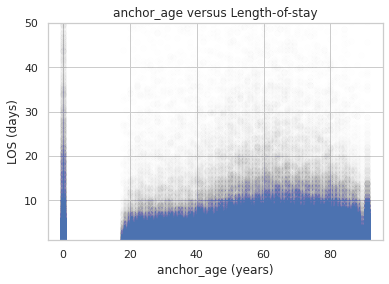

In [66]:
plt.scatter(df_admissions_data['anchor_age'], df_admissions_data['LOS'], alpha=0.005)

plt.ylabel('LOS (days)')
plt.xlabel('anchor_age (years)')
plt.title('anchor_age versus Length-of-stay')
plt.ylim(1, 50)

In [67]:
age_ranges = [(0, 13), (13, 36), (36, 56), (56, 100)]
for num, cat_range in enumerate(age_ranges):
    df_admissions_data['anchor_age'] = np.where(df_admissions_data['anchor_age'].between(cat_range[0],cat_range[1]), 
            num, df_admissions_data['anchor_age'])
    
age_dict = {0: 'newborn', 1: 'young_adult', 2: 'middle_adult', 3: 'senior'}
df_admissions_data['anchor_age'] = df_admissions_data['anchor_age'].replace(age_dict)
df_admissions_data['anchor_age'].value_counts()

senior          120136
middle_adult     67985
young_adult      41836
newborn          29692
Name: anchor_age, dtype: int64

## 2.3.2 Gender

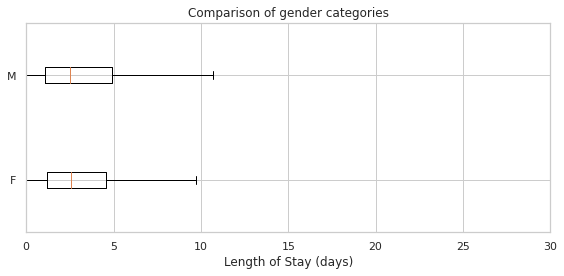

In [69]:
boxplot_los_groupby('gender', los_range=(0, 30))
df_admissions_data['gender'].replace({'M': 0, 'F':1}, inplace=True)

In [70]:
df_patients_data.head()

,subject_id,anchor_age,gender
0,10002723,0,F
1,10003939,0,M
2,10004222,0,M
3,10005325,0,F
4,10007338,0,F


# 2.4 ICUSTAYS  Exploration

In [71]:
# Intensive Care Unit (ICU) for each admission to hospital
df_icu_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69619 entries, 0 to 69618
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   subject_id      69619 non-null  int64         
 1   hadm_id         69619 non-null  int64         
 2   stay_id         69619 non-null  int64         
 3   first_careunit  69619 non-null  object        
 4   last_careunit   69619 non-null  object        
 5   intime          69619 non-null  datetime64[ns]
 6   outtime         69619 non-null  datetime64[ns]
 7   los             69619 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(3), object(2)
memory usage: 4.2+ MB


In [72]:
df_icu_data['hadm_id'].nunique()

64975

In [73]:
df_icu_data.groupby('first_careunit').median()

,subject_id,hadm_id,stay_id,los
first_careunit,,,,
Cardiac Vascular Intensive Care Unit (CVICU),14890830.0,24963225.5,35001395.5,2.069497
Coronary Care Unit (CCU),15007699.0,24963871.0,35069725.0,2.219132
Medical Intensive Care Unit (MICU),15046040.0,24971591.0,34851092.0,1.969294
Medical/Surgical Intensive Care Unit (MICU/SICU),14989695.5,25015560.5,35026040.0,1.891852
Medicine,15772294.0,27946694.0,36578359.0,3.658981
Neuro Intermediate,15005984.5,24758985.0,35119488.5,2.845694
Neuro Stepdown,14944990.0,25185450.0,34905479.0,1.913032
Neuro Surgical Intensive Care Unit (Neuro SICU),15259145.5,24942350.5,34919432.5,3.838102
PACU,14507478.0,24670135.5,34526849.5,2.289329


In [74]:
#2.4.1 ICU (Feature Engineering)

In [75]:
# Based on above statistics, reduce to just ICU and NICU groups
df_icu_data['first_careunit'].replace({'Cardiac Vascular Intensive Care Unit (CVICU)': 'ICU', 'Coronary Care Unit (CCU)': 'ICU', 'Medical Intensive Care Unit (MICU)': 'ICU',
                                  'Medical/Surgical Intensive Care Unit (MICU/SICU)': 'ICU', 'Medicine': 'ICU', 'Neuro Intermediate' : 'Neuro_ICU', 
                                  'Neuro Stepdown': 'Neuro_ICU', 'Neuro Surgical Intensive Care Unit (Neuro SICU)': 'Neuro_ICU', 'PACU' : 'ICU', 
                                  'Surgical Intensive Care Unit (SICU)': 'ICU',  'Trauma SICU (TSICU)': 'ICU'}, inplace=True)

In [76]:
df_icu_data['cat'] = df_icu_data['first_careunit']
icu_list = df_icu_data.groupby('hadm_id')['cat'].apply(list).reset_index()
icu_list.head(50)

,hadm_id,cat
0,20000094,[ICU]
1,20000147,[ICU]
2,20000351,[ICU]
3,20000397,[ICU]
4,20000808,"[ICU, ICU]"
5,20001305,[ICU]
6,20001361,[ICU]
7,20001395,[ICU]
8,20001494,[Neuro_ICU]
9,20001687,[ICU]


In [77]:
df_icu_data['first_careunit'].value_counts()

ICU          65960
Neuro_ICU     3659
Name: first_careunit, dtype: int64

In [78]:
# Create admission-ICU matrix
icu_item = pd.get_dummies(icu_list['cat'].apply(pd.Series).stack()).sum(level=0)
icu_item[icu_item >= 1] = 1
icu_item = icu_item.join(icu_list['hadm_id'], how="outer")
icu_item.head(50)

,ICU,Neuro_ICU,hadm_id
0,1,0,20000094
1,1,0,20000147
2,1,0,20000351
3,1,0,20000397
4,1,0,20000808
5,1,0,20001305
6,1,0,20001361
7,1,0,20001395
8,0,1,20001494
9,1,0,20001687


In [79]:
print("Number of admissions to ICU {}.".format(icu_item.ICU.sum()))
print("Number of admissions to Neuro_ICU {}.".format(icu_item.Neuro_ICU.sum()))

Number of admissions to ICU 61581.
Number of admissions to Neuro_ICU 3523.


In [80]:
# Merge ICU data with main dataFrame
df_admissions_data = df_admissions_data.merge(icu_item, how='outer', on='hadm_id')

In [81]:
# Replace NaNs with 0
df_admissions_data['ICU'].fillna(value=0, inplace=True)
df_admissions_data['Neuro_ICU'].fillna(value=0, inplace=True)

In [82]:
# Verify NaN fix
print(df_admissions_data.ICU.value_counts(dropna=False))
print(df_admissions_data.Neuro_ICU.value_counts(dropna=False))

0.0    228180
1.0     61581
Name: ICU, dtype: int64
0.0    286238
1.0      3523
Name: Neuro_ICU, dtype: int64


# 2.5 DRG data  Exploration

In [83]:

df_drg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168135 entries, 0 to 1168134
Data columns (total 7 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   subject_id     1168135 non-null  int64  
 1   hadm_id        1168135 non-null  int64  
 2   drg_type       1168135 non-null  object 
 3   drg_code       1168135 non-null  object 
 4   description    1160329 non-null  object 
 5   drg_severity   838563 non-null   float64
 6   drg_mortality  838563 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 62.4+ MB


In [84]:
df_drg_data.head(50)

,subject_id,hadm_id,drg_type,drg_code,description,drg_severity,drg_mortality
0,11603789,25552978,APR,5402,Cesarean Delivery,2.0,1.0
1,11603789,25552978,APR,5402,Cesarean Delivery,2.0,1.0
2,11603789,25552978,HCFA,765,CESAREAN SECTION W CC/MCC,NaN,NaN
3,16809467,29803749,APR,5601,Vaginal Delivery,1.0,1.0
4,16809467,29803749,APR,5601,Vaginal Delivery,1.0,1.0
5,16809467,29803749,HCFA,775,VAGINAL DELIVERY W/O COMPLICATING DIAGNOSES,NaN,NaN
6,11147319,25941345,HCFA,775,VAGINAL DELIVERY W/O COMPLICATING DIAGNOSES,NaN,NaN
7,11147319,25941345,APR,5601,Vaginal Delivery,1.0,1.0
8,11147319,25941345,APR,5601,Vaginal Delivery,1.0,1.0
9,12156531,29321418,APR,5602,Vaginal Delivery,2.0,1.0


In [85]:
df_drg_data['hadm_id'].nunique()

329572

## 2.5.1 drg_type (feature engineering)

In [86]:
df_drg_data['cat'] = df_drg_data['drg_type']
drg_list = df_drg_data.groupby('hadm_id')['cat'].apply(list).reset_index()
drg_list.head(50)

,hadm_id,cat
0,20000019,"[HCFA, APR, APR]"
1,20000024,"[HCFA, APR, APR]"
2,20000041,"[APR, APR, HCFA]"
3,20000055,"[APR, HCFA, APR]"
4,20000069,"[APR, HCFA, APR]"
5,20000094,"[APR, APR, HCFA]"
6,20000095,"[HCFA, APR, APR]"
7,20000102,"[HCFA, APR, APR]"
8,20000147,"[APR, HCFA, APR, APR]"
9,20000188,"[APR, HCFA, APR]"


In [87]:
df_drg_data['drg_type'].value_counts()

APR     838563
HCFA    329572
Name: drg_type, dtype: int64

In [88]:
# Create drg matrix
drg_item = pd.get_dummies(drg_list['cat'].apply(pd.Series).stack()).sum(level=0)
drg_item[drg_item >= 1] = 1
drg_item = drg_item.join(drg_list['hadm_id'], how="outer")
drg_item.head(50)

,APR,HCFA,hadm_id
0,1,1,20000019
1,1,1,20000024
2,1,1,20000041
3,1,1,20000055
4,1,1,20000069
5,1,1,20000094
6,1,1,20000095
7,1,1,20000102
8,1,1,20000147
9,1,1,20000188


In [89]:
drg_item.isnull().sum().sum()

0

In [90]:
print("Number of admissions with APR {}.".format(drg_item.APR.sum()))
print("Number of admissions with HCFA {}.".format(drg_item.HCFA.sum()))

Number of admissions with APR 329563.
Number of admissions with HCFA 329572.


In [91]:
# Merge drg data with main dataFrame
df_admissions_data = df_admissions_data.merge(drg_item, how='outer', on='hadm_id')

In [92]:
# Replace NaNs with 0
df_admissions_data['APR'].fillna(value=0, inplace=True)
df_admissions_data['HCFA'].fillna(value=0, inplace=True)

In [93]:
# Verify NaN fix
print(df_admissions_data.APR.value_counts(dropna=False))
print(df_admissions_data.HCFA.value_counts(dropna=False))

1.0    329563
0.0     75899
Name: APR, dtype: int64
1.0    329572
0.0     75890
Name: HCFA, dtype: int64


In [94]:
df_admissions_data.head(10)

,subject_id,hadm_id,admittime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,...,pregnancy,prenatal,respiratory,skin,anchor_age,gender,ICU,Neuro_ICU,APR,HCFA
0,14495017.0,22484010,2175-01-28 15:41:00,NaT,DIRECT EMER.,PHYSICIAN REFERRAL,HOME,Other,?,Unknown,...,0.0,1.0,0.0,0.0,newborn,0.0,0.0,0.0,1.0,1.0
1,14495017.0,23358160,2175-01-23 05:58:00,NaT,ELECTIVE,None,HOME,Other,ENGLISH,Unknown,...,0.0,1.0,0.0,0.0,newborn,0.0,0.0,0.0,1.0,1.0
2,13831972.0,27763544,2131-01-27 04:03:00,NaT,EU OBSERVATION,EMERGENCY ROOM,None,Medicaid,ENGLISH,SINGLE,...,0.0,0.0,0.0,0.0,middle_adult,1.0,0.0,0.0,0.0,0.0
3,13831972.0,20914383,2133-03-24 01:12:00,NaT,EU OBSERVATION,EMERGENCY ROOM,None,Medicaid,ENGLISH,SINGLE,...,0.0,0.0,0.0,0.0,middle_adult,1.0,0.0,0.0,0.0,0.0
4,13831972.0,28118473,2134-04-23 19:49:00,NaT,EU OBSERVATION,EMERGENCY ROOM,None,Medicaid,ENGLISH,SINGLE,...,0.0,0.0,0.0,0.0,middle_adult,1.0,0.0,0.0,0.0,0.0
5,13831972.0,27117659,2131-07-11 01:26:00,NaT,EU OBSERVATION,EMERGENCY ROOM,None,Medicaid,ENGLISH,SINGLE,...,0.0,0.0,0.0,0.0,middle_adult,1.0,0.0,0.0,0.0,0.0
6,13831972.0,22890331,2131-06-04 00:21:00,NaT,EU OBSERVATION,EMERGENCY ROOM,None,Medicaid,ENGLISH,SINGLE,...,0.0,0.0,0.0,0.0,middle_adult,1.0,0.0,0.0,0.0,0.0
7,13831972.0,22777023,2133-06-15 07:20:00,NaT,EU OBSERVATION,EMERGENCY ROOM,None,Medicaid,ENGLISH,SINGLE,...,0.0,0.0,0.0,1.0,middle_adult,1.0,0.0,0.0,0.0,0.0
8,13831972.0,26919298,2131-07-27 05:19:00,NaT,EU OBSERVATION,EMERGENCY ROOM,None,Medicaid,ENGLISH,SINGLE,...,0.0,0.0,0.0,0.0,middle_adult,1.0,0.0,0.0,0.0,0.0
9,13831972.0,20523273,2134-03-06 20:26:00,NaT,EU OBSERVATION,EMERGENCY ROOM,None,Medicaid,ENGLISH,SINGLE,...,0.0,0.0,0.0,0.0,middle_adult,1.0,0.0,0.0,0.0,0.0


In [95]:
# Renaming the main dataframe as final_df

In [96]:
final_df = df_admissions_data
print(final_df.shape)

(405462, 36)


# 3. Data Preprocessing

In [97]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 405462 entries, 0 to 405461
Data columns (total 36 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   subject_id          259649 non-null  float64       
 1   hadm_id             405462 non-null  int64         
 2   admittime           259649 non-null  datetime64[ns]
 3   deathtime           4399 non-null    datetime64[ns]
 4   admission_type      259649 non-null  object        
 5   admission_location  230392 non-null  object        
 6   discharge_location  190443 non-null  object        
 7   insurance           259649 non-null  object        
 8   language            259649 non-null  object        
 9   marital_status      259649 non-null  object        
 10  ethnicity           259649 non-null  object        
 11  LOS                 259649 non-null  float64       
 12  Deceased            259649 non-null  float64       
 13  blood               259649 no

In [98]:
# Remove deceased persons as they will skew LOS result
final_df = final_df[final_df['Deceased'] == 0]

# Remove LOS with negative number, likely entry form error
final_df = final_df[final_df['LOS'] > 0]

In [99]:
# Drop columns that are not needed
final_df.drop(columns=['subject_id', 'hadm_id', 'admittime', 'admission_location',
                'discharge_location', 'language','Deceased','deathtime'], inplace=True)

final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 255250 entries, 0 to 259648
Data columns (total 28 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   admission_type  255250 non-null  object 
 1   insurance       255250 non-null  object 
 2   marital_status  255250 non-null  object 
 3   ethnicity       255250 non-null  object 
 4   LOS             255250 non-null  float64
 5   blood           255250 non-null  float64
 6   circulatory     255250 non-null  float64
 7   congenital      255250 non-null  float64
 8   digestive       255250 non-null  float64
 9   endocrine       255250 non-null  float64
 10  genitourinary   255250 non-null  float64
 11  infectious      255250 non-null  float64
 12  injury          255250 non-null  float64
 13  mental          255250 non-null  float64
 14  misc            255250 non-null  float64
 15  muscular        255250 non-null  float64
 16  neoplasms       255250 non-null  float64
 17  nervous   

In [100]:
# Create dummy columns for categorical variables
prefix_cols = ['ADM', 'INS', 'ETH', 'AGE', 'MAR', 'GEN']
dummy_cols = ['admission_type', 'insurance','ethnicity', 'anchor_age', 'marital_status', 'gender']
final_df = pd.get_dummies(final_df, prefix=prefix_cols, columns=dummy_cols)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 255250 entries, 0 to 259648
Data columns (total 51 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   LOS                                255250 non-null  float64
 1   blood                              255250 non-null  float64
 2   circulatory                        255250 non-null  float64
 3   congenital                         255250 non-null  float64
 4   digestive                          255250 non-null  float64
 5   endocrine                          255250 non-null  float64
 6   genitourinary                      255250 non-null  float64
 7   infectious                         255250 non-null  float64
 8   injury                             255250 non-null  float64
 9   mental                             255250 non-null  float64
 10  misc                               255250 non-null  float64
 11  muscular                           2552

In [101]:
# Verify
final_df.head()

,LOS,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,...,AGE_newborn,AGE_senior,AGE_young_adult,MAR_DIVORCED,MAR_MARRIED,MAR_SINGLE,MAR_Unknown,MAR_WIDOWED,GEN_0.0,GEN_1.0
0,1.013194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,0,1,0
1,2.321528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,1,0,0,0,0,0,1,0,1,0
2,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,1
3,0.420833,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0,...,0,0,0,0,0,1,0,0,0,1
4,0.757639,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,...,0,0,0,0,0,1,0,0,0,1


In [102]:
# Check for any remaining NaNs
final_df.isnull().values.sum()

0

# 4. Length-of-Stay Prediction Model

#### In this section,  we will go through the implementation and selection of the supervised learning prediction model using the Scikit-Learn machine learning library.

## 4.1 Model Implementation

#### To implement the prediction model, I split the LOS target variable and features into training and test sets at an 80:20 ratio using the scikit-learn train_test_split function. Using the training set, I'll fit five different regression models (from the scikit-learn library) using default settings to see what the R2 score comparison looked like.

In [103]:
# Target Variable (Length-of-Stay)
LOS = final_df['LOS'].values
print(LOS)
# Prediction Features
features = final_df.drop(columns=['LOS'])
# print(features.shape)
# features.info()

[ 1.01319444  2.32152778  0.06666667 ... 43.03333333  2.55347222
  3.62430556]


In [104]:
# Split into train 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    LOS, 
                                                    test_size = .20, 
                                                    random_state = 42)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))


Training set has 204200 samples.
Testing set has 51050 samples.


## 4.1.1 Regression models

##### PREDICTION OF LOS USING LINEAR REGRESSION

In [106]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [107]:
# Make predictions with model
y_test_preds = lin_reg.predict(X_test)
print("Predictions:", y_test_preds)

Predictions: [4.7975502  0.58702469 5.32785416 ... 4.77009964 4.80932999 5.75966263]


In [108]:
#from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

lin_mse = mean_squared_error(y_test, y_test_preds)
lin_rmse = np.sqrt(lin_mse)
print('lin_rmse:', lin_rmse)
lin_r2 = r2_score(y_test, y_test_preds)
print('lin_r2:', lin_r2 )
lin_mae = mean_absolute_error(y_test, y_test_preds)
print('lin_mae:', lin_mae)


lin_rmse: 5.36858562364744
lin_r2: 0.37668462890174115
lin_mae: 2.6923320756182214


##### PREDICTION OF LOS USING DecisionTreeRegressor

In [110]:
#from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [111]:
# Make predictions with model
y_test_preds = tree_reg.predict(X_test)
print("Predictions:", y_test_preds)

Predictions: [1.81527778 0.43402778 6.56944444 ... 1.12638889 3.12415123 1.87152778]


In [112]:
tree_mse = mean_squared_error(y_test, y_test_preds)
tree_rmse = np.sqrt(tree_mse)
print('tree_rmse:', tree_rmse)
tree_r2 = r2_score(y_test, y_test_preds)
print('tree_r2:', tree_r2 )
tree_mae = mean_absolute_error(y_test, y_test_preds)
print('tree_mae:', tree_mae)

tree_rmse: 6.698820774891199
tree_r2: 0.029524031235569792
tree_mae: 3.0050521727060358


##### PREDICT OF LOS USING RandomForestRegressor

In [114]:
#from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [115]:
# Make predictions with model
y_test_preds = forest_reg.predict(X_test)
print("Predictions:", y_test_preds)

Predictions: [4.94624306 0.42598942 5.88384028 ... 3.24053067 3.12899043 4.86099306]


In [116]:
forest_mse = mean_squared_error(y_test, y_test_preds)
forest_rmse = np.sqrt(forest_mse)
print('forest_rmse:', forest_rmse)
forest_r2 = r2_score(y_test, y_test_preds)
print('forest_r2:', forest_r2 )
forest_mae = mean_absolute_error(y_test, y_test_preds)
print('forest_mae:', forest_mae)

forest_rmse: 4.884428710437048
forest_r2: 0.4840404927035078
forest_mae: 2.2538857453854795


##### PREDICTION OF LOS USING GradientBoostingRegressor

In [118]:
# GradientBoostingRegressor will be used as the LOS prediction model
Grad_reg = GradientBoostingRegressor(random_state=42)   
Grad_reg.fit(X_train, y_train)


GradientBoostingRegressor(random_state=42)

In [119]:
# Make predictions with model
y_test_preds = Grad_reg.predict(X_test)
print("Predictions:", y_test_preds)

Predictions: [4.85126548 0.6217718  4.49600238 ... 3.20918236 2.71991894 5.38357053]


In [120]:
grad_mse = mean_squared_error(y_test, y_test_preds)
grad_rmse = np.sqrt(grad_mse)
print('grad_rmse:', grad_rmse)
grad_r2 = r2_score(y_test, y_test_preds)
print('grad_r2:', grad_r2 )
grad_mae = mean_absolute_error(y_test, y_test_preds)
print('grad_mae:', grad_mae)

grad_rmse: 4.812587692305392
grad_r2: 0.4991065174847854
grad_mae: 2.2272853074720507


##### PREDICTION OF LOS USING SGDRegressor

In [122]:
#from sklearn.linear_model import SGDRegressor
SGD_reg = SGDRegressor(random_state=42)
SGD_reg.fit(X_train, y_train)


SGDRegressor(random_state=42)

In [123]:
# Make predictions with model
y_test_preds = SGD_reg.predict(X_test)
print("Predictions:", y_test_preds)

Predictions: [4.36141135 0.516975   5.24385676 ... 5.12074403 4.95425429 5.50249297]


In [124]:
SGD_mse = mean_squared_error(y_test, y_test_preds)
SGD_rmse = np.sqrt(SGD_mse)
print('SGD_rmse:', SGD_rmse)
SGD_r2 = r2_score(y_test, y_test_preds)
print('SGD_r2:', SGD_r2 )
SGD_mae = mean_absolute_error(y_test, y_test_preds)
print('SGD_mae:', SGD_mae)

SGD_rmse: 5.377005232654306
SGD_r2: 0.37472799175978255
SGD_mae: 2.74083874440942


In [125]:
# OR FOR EASY DOING WE CAN FOLLOW THE BELOW CODE

In [126]:
# Regression models for comparison
models = [LinearRegression(), RandomForestRegressor(random_state = 42),
          DecisionTreeRegressor(random_state=42), 
          GradientBoostingRegressor(random_state = 42),
          SGDRegressor(random_state = 42), KNeighborsRegressor()]

results = {}

for model in models:
    
    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_train, y_train)
    
    # Make predictions with model
    y_test_preds = reg_model.predict(X_test)
    
    # Grab model name and store results associated with model
    name = str(model).split("(")[0]

    results[name] = r2_score(y_test, y_test_preds)
    print('{} done.'.format(name))

LinearRegression done.
RandomForestRegressor done.
DecisionTreeRegressor done.
GradientBoostingRegressor done.
SGDRegressor done.
KNeighborsRegressor done.


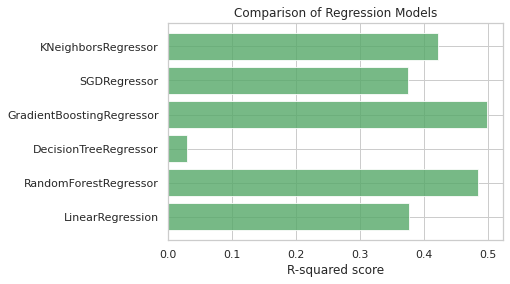

In [127]:
# R2 score results
fig, ax = plt.subplots()
ind = range(len(results))
ax.barh(ind, list(results.values()), align='center', 
        color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(results.keys())
ax.set_xlabel('R-squared score')
ax.tick_params(left=False, top=False, right=False) 
ax.set_title('Comparison of Regression Models')
fig.savefig('images/compare_models.png', bbox_inches = 'tight')

#The GradientBoostingRegressor better R2 score value of ~49% so I decided to focus on refining this particular model. Because of past success with the RandomForestRegressor, I played with that model’s parameters but was never able to exceed the GradientBoostingRegressor score.

In [128]:
# GradientBoostingRegressor will be used as the LOS prediction model
reg_model = GradientBoostingRegressor(random_state=42)   
reg_model.fit(X_train, y_train)
y_test_preds = reg_model.predict(X_test)
r2_not_refined = r2_score(y_test, y_test_preds)
print("R2 score is: {:2f}".format(r2_not_refined))

R2 score is: 0.499107


# 5. Evaluation of the models


### 5.1 Better Evaluation Using Cross-Validation

#### Scikit-Learn’s K-fold cross-validation feature :
#### The following code randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the regression model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores.

In [129]:
# from sklearn.model_selection import cross_val_score

##### cross validation Decisiontree regression model

In [131]:

scores = cross_val_score(tree_reg, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [132]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [6.43989832 6.73521846 6.67972448 6.99472495 6.62441062 7.294335
 7.72351524 6.73124668 6.5924231  6.60367436]
Mean: 6.841917118821179
Standard deviation: 0.3719034127497248


##### cross validation of Linear regression model

In [134]:
lin_scores = cross_val_score(lin_reg, X_train, y_train,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [5.19934624 5.39214326 5.30735078 5.45817426 5.29912029 5.29112751
 6.39397118 5.42246003 4.94598855 4.84695803]
Mean: 5.355664014203493
Standard deviation: 0.3943513534701519


##### cross validation of Random forest regression model

In [136]:
forest_scores = cross_val_score(forest_reg, X_train, y_train ,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [4.63184867 4.78172146 4.77709678 5.09658726 4.80629579 4.8247335
 5.96342022 4.80057613 4.47125783 4.47648406]
Mean: 4.863002168629715
Standard deviation: 0.4055042666449539


##### cross validation of GradientBoostingRegressor model

In [137]:
Grad_scores = cross_val_score(Grad_reg, X_train, y_train ,
                                scoring="neg_mean_squared_error", cv=10)
Grad_rmse_scores = np.sqrt(-Grad_scores)
display_scores(Grad_rmse_scores)

Scores: [4.62306138 4.62526276 4.71930098 5.08765712 4.76554064 4.70174005
 5.92323525 4.76864458 4.40084794 4.39154009]
Mean: 4.800683078456569
Standard deviation: 0.4184184014331284


# 6. Fine-tune your model

### 6.1 Grid Search

#### Here we need to tell which hyperparameters we want  to experiment with and what values to try out, and it will use cross-validation to evaluate all the possible combinations of hyperparameter values.

#### This param_grid tells Scikit-Learn to evaluate all 3 × 3 x 3 = 27 combinations of n_estimators, max_depth and max_features hyperparameter values specified in the dict. The grid search will explore 27 combinations of GradientBoostingRegressor hyperparameter values, and it will train each model 5 times (since we are using five-fold cross validation). In other words, all in all, there will be 27 × 5 = 135 rounds of training! It may take quite a long time, but when it is done we can get the best combination of parameters as follows:

In [138]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    #{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    
    #{ 'n_estimators': [100, 200, 300], 'max_features': [2, 4, 6, 8]},
    # try 6 (2×3) combinations of hyperparameters
    #{'n_estimators': [300, 400, 500], 'max_features': [8, 10, 12]}
    {'n_estimators': [500, 1000, 2000], 'max_depth' : [2, 3, 4], 'max_features': [8, 10, 12]}
  ]

Grad_reg = GradientBoostingRegressor(random_state=42) 
# train across 5 folds, that's a total of (6)*5=30 rounds of training 
grid_search = GridSearchCV(Grad_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(X_train, y_train)




GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             param_grid=[{'max_depth': [2, 3, 4], 'max_features': [8, 10, 12],
                          'n_estimators': [500, 1000, 2000]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [139]:
print('Best hyperparameters combination found:')

grid_search.best_params_

Best hyperparameters combination found:


{'max_depth': 4, 'max_features': 12, 'n_estimators': 1000}

In [140]:
grid_search.best_estimator_

GradientBoostingRegressor(max_depth=4, max_features=12, n_estimators=1000,
                          random_state=42)

In [141]:
print('The evaluation scores are available as follows:')

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

The evaluation scores are available as follows:
4.862046234709903 {'max_depth': 2, 'max_features': 8, 'n_estimators': 500}
4.827743921881687 {'max_depth': 2, 'max_features': 8, 'n_estimators': 1000}
4.796714229203087 {'max_depth': 2, 'max_features': 8, 'n_estimators': 2000}
4.863235012618654 {'max_depth': 2, 'max_features': 10, 'n_estimators': 500}
4.825962047528129 {'max_depth': 2, 'max_features': 10, 'n_estimators': 1000}
4.792716316786383 {'max_depth': 2, 'max_features': 10, 'n_estimators': 2000}
4.86210828268407 {'max_depth': 2, 'max_features': 12, 'n_estimators': 500}
4.827401359334576 {'max_depth': 2, 'max_features': 12, 'n_estimators': 1000}
4.787712474948403 {'max_depth': 2, 'max_features': 12, 'n_estimators': 2000}
4.776938484462628 {'max_depth': 3, 'max_features': 8, 'n_estimators': 500}
4.755704134402553 {'max_depth': 3, 'max_features': 8, 'n_estimators': 1000}
4.751714438354374 {'max_depth': 3, 'max_features': 8, 'n_estimators': 2000}
4.7686217160500695 {'max_depth': 3, 'ma

In [142]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,11.301777,0.031256,0.172773,0.009981,2,8,500,"{'max_depth': 2, 'max_features': 8, 'n_estimat...",-21.860932,-24.285782,...,-23.639494,3.282050,25,-23.130708,-22.524132,-22.774643,-21.328228,-23.529684,-22.657479,0.746070
1,22.477724,0.099830,0.319279,0.012697,2,8,1000,"{'max_depth': 2, 'max_features': 8, 'n_estimat...",-21.602320,-23.899373,...,-23.307111,3.246143,24,-22.441366,-21.858212,-22.010491,-20.654750,-22.807501,-21.954464,0.730261
2,45.097670,0.193389,0.612856,0.021705,2,8,2000,"{'max_depth': 2, 'max_features': 8, 'n_estimat...",-21.245861,-23.626528,...,-23.008467,3.226067,21,-21.353879,-20.846173,-21.128539,-19.772572,-21.765963,-20.973425,0.671590
3,13.631852,0.016159,0.169161,0.005217,2,10,500,"{'max_depth': 2, 'max_features': 10, 'n_estima...",-21.673108,-24.356174,...,-23.651055,3.299342,27,-22.975611,-22.599564,-22.703660,-21.331621,-23.607415,-22.643574,0.743775
4,27.033294,0.026740,0.318804,0.013204,2,10,1000,"{'max_depth': 2, 'max_features': 10, 'n_estima...",-21.461653,-23.974937,...,-23.289910,3.270281,22,-22.068112,-21.769556,-21.772139,-20.607671,-22.688683,-21.781232,0.675756
5,54.054635,0.239758,0.632816,0.027809,2,10,2000,"{'max_depth': 2, 'max_features': 10, 'n_estima...",-21.325953,-23.655518,...,-22.970130,3.183442,20,-21.088435,-20.905510,-20.873551,-19.583250,-21.573145,-20.804778,0.659978
6,15.801287,0.033532,0.158588,0.001495,2,12,500,"{'max_depth': 2, 'max_features': 12, 'n_estima...",-21.870263,-24.526484,...,-23.640097,3.419927,26,-22.945323,-22.650375,-22.482988,-21.350858,-23.643360,-22.614581,0.746106
7,31.298479,0.102567,0.307724,0.026816,2,12,1000,"{'max_depth': 2, 'max_features': 12, 'n_estima...",-21.640312,-24.101977,...,-23.303804,3.295781,23,-22.174464,-21.883181,-21.692754,-20.547925,-22.730112,-21.805687,0.719900
8,62.756182,0.128397,0.645248,0.064092,2,12,2000,"{'max_depth': 2, 'max_features': 12, 'n_estima...",-21.256710,-23.505723,...,-22.922191,3.216084,19,-21.105083,-20.778465,-20.802623,-19.564478,-21.562204,-20.762571,0.662421
9,16.511297,0.025061,0.193741,0.002990,3,8,500,"{'max_depth': 3, 'max_features': 8, 'n_estimat...",-20.861297,-23.565182,...,-22.819141,3.222605,17,-20.727344,-20.229498,-20.563480,-19.626556,-21.215910,-20.472558,0.529255


In [143]:
y_test_preds = grid_search.best_estimator_.predict(X_test)
r2_optimized = r2_score(y_test, y_test_preds)
print("Optimized R2 score is: {:f}".format(r2_optimized))

Optimized R2 score is: 0.521453


In [144]:
print('Fine tuning of the model improved R2 score by {:.4f}'.format(r2_optimized-r2_not_refined))

Fine tuning of the model improved R2 score by 0.0223


#### In this, we obtain the best solution by setting the max_features hyperparameter to 12 and the n_estimators hyperparameter to 1000. The RMSE score for this combination is 4.73, which is slightly better than the score we got earlier using the default hyperparameter values (which was 4.8). Also, R2 score improved from 0.499 to 0.5214. Fine tuning of the model improved R2 score by 0.0223

### 6.2 Randomized Search

#### The grid search approach is fine when you are exploring relatively few combinations, like in the previous example, but when the hyperparameter search space is large, it is often preferable to use RandomizedSearchCV instead. This class can be used in much the same way as the GridSearchCV class, but instead of trying out all possible combinations, it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration. If you let the randomized search run for, say, 1,000 iterations, this approach will explore 1,000 different values for each hyperparameter (instead of just a few values per hyperparameter with the grid search approach)

In [145]:
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import randint

# param_distribs = {
#         'n_estimators': randint(low=500, high=2000),
#         'max_features': randint(low=2, high=16),
#     }
# Grad_reg = GradientBoostingRegressor(random_state=42)

# rnd_search = RandomizedSearchCV(Grad_reg, param_distributions=param_distribs,
#                                 n_iter=1000, cv=5, scoring='neg_mean_squared_error', random_state=42)
# rnd_search.fit(X_train, y_train)

In [146]:
# cvres = rnd_search.cv_results_
# for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#     print(np.sqrt(-mean_score), params)

# 7. Feature importance

#### Now the GradientBoostingRegressor can indicate the relative importance of each attribute for making accurate predictions: With this information, we can try dropping some of the less useful features. 


In [147]:
feature_imp = pd.DataFrame(grid_search.best_estimator_.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

feature_imp.head(20)

,importance
prenatal,0.307427
ICU,0.080089
infectious,0.072747
injury,0.059562
digestive,0.053654
nervous,0.051426
respiratory,0.048830
APR,0.039393
blood,0.034170
congenital,0.026062


In [148]:
feature_imp.index[0:20].tolist()

['prenatal',
 'ICU',
 'infectious',
 'injury',
 'digestive',
 'nervous',
 'respiratory',
 'APR',
 'blood',
 'congenital',
 'ADM_EU OBSERVATION',
 'misc',
 'HCFA',
 'skin',
 'ADM_URGENT',
 'endocrine',
 'mental',
 'neoplasms',
 'genitourinary',
 'AGE_newborn']

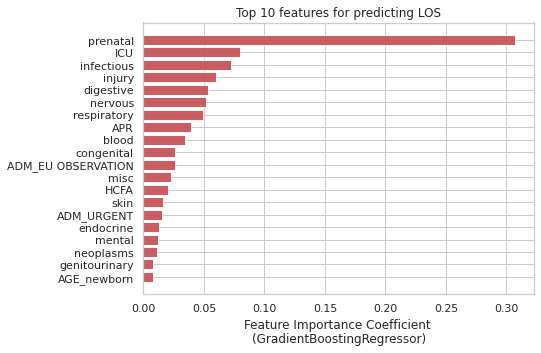

In [149]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(7, 5))
ind = range(0,20)
ax.barh(ind, feature_imp['importance'].values[0:20], 
        align='center', color='#c44e52', alpha=0.9)
ax.set_yticks(ind)
ax.set_yticklabels(feature_imp.index[0:20].tolist())
ax.tick_params(left=False, top=False, right=False) 
ax.set_title("Top 10 features for predicting LOS")
ax.set_xlabel('Feature Importance Coefficient \n(GradientBoostingRegressor)')
plt.gca().invert_yaxis()
fig.savefig('images/feature_importance.png', bbox_inches = 'tight')

In [150]:
# y_test_preds = Grad_reg.predict(X_test)

ml_count, md_count, avg_count  = 0, 0, 0
ml_days, md_days, avg_days  = 0, 0, 0
ml_days_rms, md_days_rms, avg_days_rms  = 0, 0, 0

for i in range(y_test_preds.shape[0]):
    ml_model = abs(y_test_preds[i] - y_test[i])
    median_model = abs(actual_median_los - y_test[i])
    average_model = abs(actual_mean_los - y_test[i])
    
    ml_days += ml_model
    md_days += median_model
    avg_days += average_model
    
    ml_model_rms = (y_test_preds[i] - y_test[i])**2
    median_model_rms = (actual_median_los - y_test[i])**2
    average_model_rms = (actual_mean_los - y_test[i])**2
    
    ml_days_rms += ml_model_rms
    md_days_rms += median_model_rms
    avg_days_rms += average_model_rms

print("Prediction Model days {}".format(ml_days/y_test_preds.shape[0]))
print("Median Model days {}".format(md_days/y_test_preds.shape[0]))
print("Average Model days {}".format(avg_days/y_test_preds.shape[0]))

print("Prediction Model RMS {}".format((ml_days_rms**0.5)/y_test_preds.shape[0]))
print("Median Model RMS {}".format((md_days_rms**0.5)/y_test_preds.shape[0]))
print("Average Model RMS {}".format((avg_days_rms**0.5)/y_test_preds.shape[0]))

Prediction Model days 2.1604114885617007
Median Model days 2.9700631325497984
Average Model days 3.4680636634027535
Prediction Model RMS 0.020819499932109027
Median Model RMS 0.03085713568030974
Average Model RMS 0.030120159455272


# Extra Material

###  Using onehotencoder

#### Scikit-Learn provides a OneHotEncoder class to convert categorical values into onehotvectors. This will create one binary attribute per category: one attribute equal to 1 when the category is “Female” (and 0 when "Male"). This is called one-hot encoding, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold). The new attributes are sometimes called dummy attributes.

In [151]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse=False)
gender_cat_1hot = cat_encoder.fit_transform(df_patients_data[["gender"]])
gender_cat_1hot



array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [152]:
cat_encoder.categories_



[array(['F', 'M'], dtype=object)]

In [153]:
print(gender_cat_1hot.shape)

x = pd.DataFrame(gender_cat_1hot )
x

(383220, 2)


,0,1
0,1.0,0.0
1,0.0,1.0
2,0.0,1.0
3,1.0,0.0
4,1.0,0.0
...,...,...
383215,0.0,1.0
383216,0.0,1.0
383217,0.0,1.0
383218,0.0,1.0
